# Practical Machine Learning for Physicists
## Week 4 Exercise - Part 2


For both of these tasks we want you to implement autoencoder networks that:
- Train on randomly generated circles (using the circle_generator function below)
- Use 27x27 pixel images
- Use no more than 30,000 randomly generated samples (e.g. batchsize 30 and 1000 steps, or batchsize 1000 and 30 steps, or anywhere inbetween) in training the final networks for each task
- Use the mean_squared_error loss function
- Fulfil the network size requirement listed in the task (can be verifired using the print_layers function, after the network is partially trained)

### Task 1:
Implement any network design, but the bottleneck must contain no more than 9 neurons.

### Task 2:
Implement any network design, but the bottleneck must contain no more than 3 neurons.



#### Practicalities
You should use this notebook for your work and upload it to both Moodle and CoCalc. You are expected to use TensorFlow and Keras to complete these tasks. The notebook should be self-contained and able to be executed if necessary. Marks will be awarded for (roughly equally weighted):
- Overall notebook clarity (both in terms of good coding practice and coherent discussion)
- Task 1 performance (0.02 is a good target cost to do better than)
- Task 2 performance ( a good target here is left for the student to determine)



In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math
import keras
import keras.layers


2023-02-08 12:08:56.204376: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-08 12:08:56.476366: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-08 12:08:56.487056: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-08 12:08:56.487090: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

In [2]:
#A big messy function to do the training
# model -- our keras neural model autoencoder
# image_generator -- a function to generate random images for the training (see below for examples)
# img_size -- the size of our image in pixels
# batchsize -- the number of images to include in each training batch
# steps -- the number of steps taken in the training
#
# returns an array of the costs
def generate_and_train(model,image_generator,img_size,batchsize,steps):
   
    #Generate an array of the numbers 1 to img_size and create a meshgrid from them    
    pixels=np.linspace(-1,1,img_size)
    x,y=np.meshgrid(pixels,pixels)
    
    #Now create a test image using 1 call to image_generator
    #y_test=np.zeros([1,pixels,pixels,1])
    #y_test[:,:,:,0]=image_generator(1,x,y)
    
    #Now create the empty arrays for the images and cost
    y_in=np.zeros([batchsize,img_size,img_size,1])
    y_target=np.zeros([batchsize,img_size,img_size,1])
    cost=np.zeros(steps)
    
    #Loop through the steps, get a random batch of samples, train the model, repeat
    for k in range(steps):
        # produce samples:
        y_in[:,:,:,0]=image_generator(batchsize,x,y)
        y_target=np.copy(y_in) # autoencoder wants to reproduce its input!
        
        # do one training step on this batch of samples:
        cost[k]=model.train_on_batch(y_in,y_target)
    
    return cost,y_target

def get_test_image(image_generator,img_size):
    #Generate an array of the numbers 1 to img_size and create a meshgrid from them    
    pixels=np.linspace(-1,1,img_size)
    x,y=np.meshgrid(pixels,pixels)
    
    #Now create a test image using 1 call to image_generator
    y_test=np.zeros([1,img_size,img_size,1])
    y_test[:,:,:,0]=image_generator(1,x,y)
    return y_test

# A function to generate and plot a single test image and the output of our model
# only to be called after training the model
def plot_test_image(model,image_generator,img_size):
    #Get random test image
    y_test=get_test_image(image_generator,img_size)
    
    #Create the output image
    y_test_out=model.predict_on_batch(y_test)
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(y_test[0,:,:,0],origin='lower')
    ax[0].set_title("Input")
    ax[1].imshow(y_test_out[0,:,:,0],origin='lower')
    ax[1].set_title("Output")
    
def print_layers(network, y_in):
    """
    Call this on some test images y_in, to get a print-out of
    the layer sizes. Shapes shown are (batchsize,pixels,pixels,channels).
    After a call to the visualization routine, y_target will contain
    the last set of training images, so you could feed those in here.
    """
    layer_features = get_layer_activations(network,y_in)
    #print(layer_features)
    for idx,feature in enumerate(layer_features): #type: ignore
        s=np.shape(feature)
        print("Layer "+str(idx)+": "+str(s[1]*s[2]*s[3])+" neurons / ", s)

def get_layer_activation_extractor(network):
    #print(network.inputs)
    #for layer in network.layers:
    #    print(layer.output)
    return(keras.Model(inputs=network.inputs,
                            outputs=[layer.output for layer in network.layers]))

def get_layer_activations(network, y_in):
    """
    Call this on some test images y_in, to get the intermediate 
    layer neuron values. These are returned in a list, with one
    entry for each layer (the entries are arrays).
    """
    extractor=get_layer_activation_extractor(network)
    #print(extractor)
    layer_features = extractor(y_in)
    return layer_features
    

## Circle generator


In [3]:
# A simple image generator that returns an array of batchsize images
# each image has a size of x * y pixels
# in this image each image has a randomly placed circle (and the circle is of random size)
def generate_circle(batchsize, x, y):
    R=np.random.uniform(size=batchsize)
    x0=np.random.uniform(size=batchsize,low=-1,high=1)
    y0=np.random.uniform(size=batchsize,low=-1,high=1)
    return( 1.0*((x[None,:,:]-x0[:,None,None])**2 + (y[None,:,:]-y0[:,None,None])**2 < R[:,None,None]**2) ) #type: ignore


Increased first convolutional layer to 32 filters, but this reduced the performance. Tried 16 which increased it substantially. Then altered the number of steps and the batchsize to be in line with exercise requirements. This reduced the performace. Reduced filter size of first layer from 5 to 2 which increased oerformance, but reduced performance substantially when the filter size of the second layer was reduced.

In [4]:
model=keras.models.Sequential()
model.add(keras.layers.Conv2D(16, 2, input_shape = (27, 27, 1), activation = "sigmoid", padding = 'same'))
model.add(keras.layers.AveragePooling2D(pool_size = (3,3), padding = 'same')) # down
model.add(keras.layers.Conv2D(4, 5, activation = "sigmoid", padding = 'same'))
model.add(keras.layers.AveragePooling2D(pool_size = (3,3), padding = 'same')) # down
model.add(keras.layers.Conv2D(1, 3, activation = "sigmoid", padding = 'same'))
model.add(keras.layers.UpSampling2D(size = (3, 3))) # up
model.add(keras.layers.Conv2D(4, 5, activation = "sigmoid", padding = 'same'))
model.add(keras.layers.UpSampling2D(size = (3,3))) # up
model.add(keras.layers.Conv2D(4, 5, activation = "sigmoid", padding = 'same'))
model.add(keras.layers.Conv2D(1, 3, activation = "linear", padding = 'same'))

model.compile(loss = 'mean_squared_error', optimizer = 'adam')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 27, 27, 16)        80        
                                                                 
 average_pooling2d (AverageP  (None, 9, 9, 16)         0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 9, 9, 4)           1604      
                                                                 
 average_pooling2d_1 (Averag  (None, 3, 3, 4)          0         
 ePooling2D)                                                     
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 1)           37        
                                                                 
 up_sampling2d (UpSampling2D  (None, 9, 9, 1)          0

2023-02-08 12:08:58.379244: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-02-08 12:08:58.379325: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-08 12:08:58.379402: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (penguin): /proc/driver/nvidia/version does not exist
2023-02-08 12:08:58.379805: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Text(0, 0.5, 'Cost')

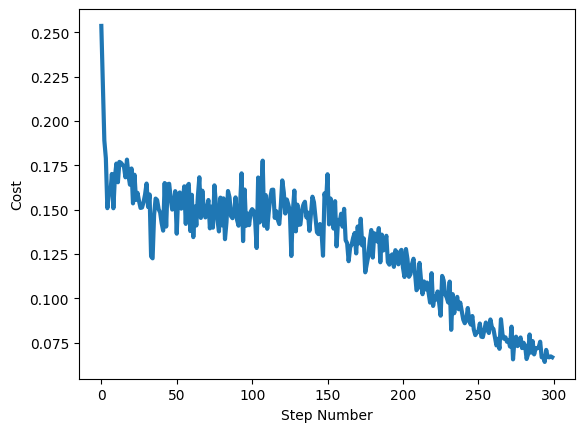

In [5]:
#Now we can do the actual model training
steps = 300
cost, y_target = generate_and_train(model, generate_circle, img_size = 9*3, batchsize = 100, steps = steps)
#Plot the cost
fig, ax = plt.subplots()
stepArray=np.arange(steps) 
ax.plot(stepArray,cost,linewidth=3) 
ax.set_xlabel("Step Number") 
ax.set_ylabel("Cost")

In [6]:
print(cost[-1])

0.06670617312192917


In [7]:
print_layers(model, y_target)

Layer 0: 11664 neurons /  (100, 27, 27, 16)
Layer 1: 1296 neurons /  (100, 9, 9, 16)
Layer 2: 324 neurons /  (100, 9, 9, 4)
Layer 3: 36 neurons /  (100, 3, 3, 4)
Layer 4: 9 neurons /  (100, 3, 3, 1)
Layer 5: 81 neurons /  (100, 9, 9, 1)
Layer 6: 324 neurons /  (100, 9, 9, 4)
Layer 7: 2916 neurons /  (100, 27, 27, 4)
Layer 8: 2916 neurons /  (100, 27, 27, 4)
Layer 9: 729 neurons /  (100, 27, 27, 1)


In [8]:
model2=keras.models.Sequential()
model2.add(keras.layers.Conv2D(9, 5, input_shape = (27, 27, 1), activation = "sigmoid", padding = 'same'))
model2.add(keras.layers.AveragePooling2D(pool_size = (3, 3), padding = 'same')) # down
model2.add(keras.layers.Conv2D(3, 5, activation = "sigmoid", padding = 'same'))
model2.add(keras.layers.AveragePooling2D(pool_size = (3, 3), padding = 'same')) # down
#model2.add(keras.layers.Conv2D(1, 3, activation = "sigmoid", padding = 'same'))
model2.add(keras.layers.AveragePooling2D(pool_size = (3, 3), padding = 'same')) # down
model2.add(keras.layers.UpSampling2D(size = (3, 3))) # up
model2.add(keras.layers.UpSampling2D(size = (3, 3))) # up
model2.add(keras.layers.Conv2D(3, 5, activation = "sigmoid", padding = 'same'))
model2.add(keras.layers.UpSampling2D(size = (3, 3))) # up
model2.add(keras.layers.Conv2D(9, 5, activation = "sigmoid", padding = 'same'))
model2.add(keras.layers.Conv2D(1, 3, activation = "linear", padding = 'same'))

model2.compile(loss = 'mean_squared_error', optimizer = 'adam')
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 27, 27, 9)         234       
                                                                 
 average_pooling2d_2 (Averag  (None, 9, 9, 9)          0         
 ePooling2D)                                                     
                                                                 
 conv2d_7 (Conv2D)           (None, 9, 9, 3)           678       
                                                                 
 average_pooling2d_3 (Averag  (None, 3, 3, 3)          0         
 ePooling2D)                                                     
                                                                 
 average_pooling2d_4 (Averag  (None, 1, 1, 3)          0         
 ePooling2D)                                                     
                                                      

Text(0, 0.5, 'Cost')

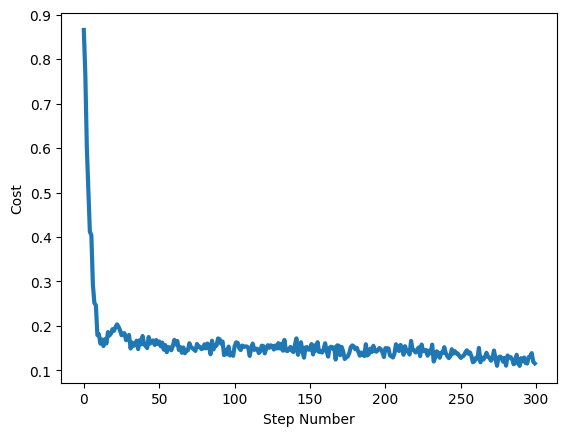

In [9]:
#Now we can do the actual model training
steps = 300
cost, y_target = generate_and_train(model2, generate_circle, img_size = 9*3, batchsize = 100, steps = steps)
#Plot the cost
fig, ax = plt.subplots()
stepArray=np.arange(steps) 
ax.plot(stepArray,cost,linewidth=3) 
ax.set_xlabel("Step Number") 
ax.set_ylabel("Cost")

In [10]:
print(cost[-1])

0.11578822880983353
